# Load Data

In [7]:
import gc
import os
import numpy as np
import pandas as pd
import subprocess
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif

In [8]:
def check_fline(fpath):
    """check total number of lines of file for large files
    
    Args:
    fpath: string. file path
    
    Returns:
    None
    
    """
    lines = subprocess.run(['wc', '-l', fpath], stdout=subprocess.PIPE).stdout.decode('utf-8')
    print(lines, end='', flush=True)

In [9]:
fs=['./data/train.csv', './data/test.csv', './data/weather_test.csv',
    './data/weather_train.csv','./data/building_metadata.csv']
[check_fline(s) for s in fs]

20216101 ./data/train.csv
41697601 ./data/test.csv
277244 ./data/weather_test.csv
139774 ./data/weather_train.csv
1450 ./data/building_metadata.csv


[None, None, None, None, None]

In [10]:
# Load sample training data
df_train = pd.read_csv('./data/train.csv')
df_train_weather = pd.read_csv('./data/weather_train.csv')
df_test = pd.read_csv('./data/test.csv')
df_test_weather = pd.read_csv('./data/weather_test.csv')
df_building = pd.read_csv('./data/building_metadata.csv')

# Basic Data Structure

In [11]:
# Show data shape
[print(item.shape) for item in [df_train,df_train_weather,df_test,df_test_weather,df_building]]

(20216100, 4)
(139773, 9)
(41697600, 4)
(277243, 9)
(1449, 6)


[None, None, None, None, None]

We need to predict meter reading given building id, meter, and timestamp. 

building_meta.csv --> train.csv by 'building_id'.

weather.csv --> building_meta.csv by 'site_id' --> train.csv by 'timestamp'

In [12]:
df_train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [13]:
df_test.head()

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00
3,3,3,0,2017-01-01 00:00:00
4,4,4,0,2017-01-01 00:00:00


In [14]:
df_train_weather.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [15]:
df_building.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [16]:
df_train_total = pd.merge(df_train,df_building,how='left',on='building_id')
df_train_total = pd.merge(df_train_total,df_train_weather,how='left',on=["site_id", "timestamp"])

In [17]:
df_train_total.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


In [18]:
df_test_total = pd.merge(df_test,df_building,how='left',on='building_id')
df_test_total = pd.merge(df_test_total,df_test_weather,how='left',on=["site_id", "timestamp"])

In [19]:
df_test_total.head()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,0,2017-01-01 00:00:00,0,Education,7432,2008.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,1,1,0,2017-01-01 00:00:00,0,Education,2720,2004.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
2,2,2,0,2017-01-01 00:00:00,0,Education,5376,1991.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
3,3,3,0,2017-01-01 00:00:00,0,Education,23685,2002.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
4,4,4,0,2017-01-01 00:00:00,0,Education,116607,1975.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6


# Explore Unique Values

In [20]:
def feat_value_count(df,colname):
    """value count of each feature
    
    Args
    df: data frame.
    colname: string. Name of to be valued column
    
    Returns
    df_count: data frame.
    """
    df_count = df[colname].value_counts().to_frame().reset_index()
    df_count = df_count.rename(columns={'index':colname+'_values',colname:'counts'})
    return df_count

In [21]:
feat_value_count(df_train,'building_id')

,building_id_values,counts
0,1298,35136
1,1249,35136
2,1301,35128
3,1241,35116
4,1296,35115
...,...,...
1444,783,2657
1445,420,2327
1446,53,1685
1447,604,1012


A total of 1449 buildings are in train data. Building 1298 has the most records and building 403 has the least records.

In [22]:
feat_value_count(df_test,'building_id')

,building_id_values,counts
0,1258,70080
1,1241,70080
2,1331,70080
3,1301,70080
4,1298,70080
...,...,...
1444,669,17520
1445,668,17520
1446,667,17520
1447,666,17520


In [23]:
len(set(df_train.building_id) & set(df_test.building_id))

1449

It looks that we need to predict all 1449 building meter readings. All buildings that need to be predicted appear in train data.

In [24]:
feat_value_count(df_train,'meter')

,meter_values,counts
0,0,12060910
1,1,4182440
2,2,2708713
3,3,1264037


Looks like meter 0: electricity has the most record.

In [25]:
feat_value_count(df_train_weather,'site_id')

,site_id_values,counts
0,8,8784
1,0,8784
2,13,8783
3,4,8783
4,2,8783
5,10,8782
6,6,8782
7,9,8780
8,3,8780
9,14,8777


In [26]:
feat_value_count(df_building,'primary_use')

,primary_use_values,counts
0,Education,549
1,Office,279
2,Entertainment/public assembly,184
3,Public services,156
4,Lodging/residential,147
5,Other,25
6,Healthcare,23
7,Parking,22
8,Warehouse/storage,13
9,Manufacturing/industrial,12


In [27]:
feat_value_count(df_building,'site_id')

,site_id_values,counts
0,3,274
1,13,154
2,2,135
3,15,124
4,9,124
5,0,105
6,14,102
7,4,91
8,5,89
9,8,70


# Check Data Types

In [28]:
df_train_total.dtypes

building_id             int64
meter                   int64
timestamp              object
meter_reading         float64
site_id                 int64
primary_use            object
square_feet             int64
year_built            float64
floor_count           float64
air_temperature       float64
cloud_coverage        float64
dew_temperature       float64
precip_depth_1_hr     float64
sea_level_pressure    float64
wind_direction        float64
wind_speed            float64
dtype: object

Timestamp column need to be refined.

In [29]:
df_train_total["timestamp"] = pd.to_datetime(df_train_total["timestamp"], format='%Y-%m-%d %H:%M:%S')
df_test_total["timestamp"] = pd.to_datetime(df_test_total["timestamp"], format='%Y-%m-%d %H:%M:%S')

# Check Missing Values

In [30]:
def check_missing(df,cols=None,axis=0):
    """check data frame column missing situation
    Args
    df: data frame.
    cols: list. List of column names
    axis: int. 0 means column and 1 means row
    
    Returns
    missing_info: data frame. 
    """
    if cols != None:
        df = df[cols]
    missing_num = df.isnull().sum(axis).to_frame().rename(columns={0:'missing_num'})
    missing_num['missing_percent'] = df.isnull().mean(axis)*100
    return missing_num.sort_values(by='missing_percent',ascending = False) 

In [31]:
df_colmissing = check_missing(df_train_total,cols=None,axis=0)
df_colmissing

,missing_num,missing_percent
floor_count,16709167,82.652772
year_built,12127645,59.990033
cloud_coverage,8825365,43.655131
precip_depth_1_hr,3749023,18.544739
wind_direction,1449048,7.167792
sea_level_pressure,1231669,6.092515
wind_speed,143676,0.710701
dew_temperature,100140,0.495348
air_temperature,96658,0.478124
building_id,0,0.000000


In [32]:
df_rowmissing = check_missing(df_train_total,cols=None,axis=1)
df_rowmissing.head()

,missing_num,missing_percent
19072677,9,56.25
6896746,9,56.25
2966016,9,56.25
2966017,9,56.25
2966018,9,56.25


# Target Explore

In [33]:
print(max(df_train_total.timestamp),min(df_train_total.timestamp))

2016-12-31 23:00:00 2016-01-01 00:00:00


In [34]:
print(max(df_test_total.timestamp),min(df_test_total.timestamp))

2018-12-31 23:00:00 2017-01-01 00:00:00


So we have train data span the whole 2016 and we need to predict from day one of 2017 to the end of 2018.

## single building

In [35]:
df_one_building = df_train_total[df_train_total.building_id == 1258]

In [36]:
df_one_building.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
1881,1258,0,2016-01-01 00:00:00,910.464,14,Education,273234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1882,1258,1,2016-01-01 00:00:00,2509.150,14,Education,273234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1883,1258,2,2016-01-01 00:00:00,2923.120,14,Education,273234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1884,1258,3,2016-01-01 00:00:00,891.480,14,Education,273234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4177,1258,0,2016-01-01 01:00:00,916.448,14,Education,273234,NaN,NaN,5.6,0.0,-0.6,0.0,1019.3,300.0,2.6


/home/jinpwa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/home/jinpwa/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


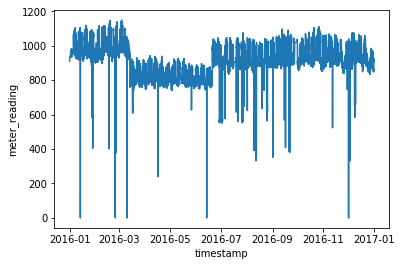

In [37]:
# electricity
sns.lineplot(x='timestamp',y='meter_reading',data=df_one_building[df_train_total.meter == 0])

Looks like there are some outliers.

/home/jinpwa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


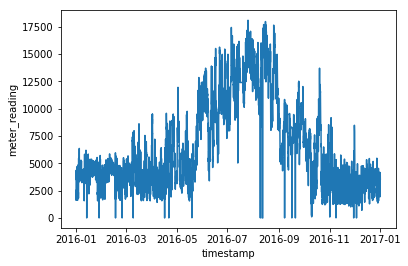

In [38]:
# chilledwater
sns.lineplot(x='timestamp',y='meter_reading',data=df_one_building[df_train_total.meter == 1])

/home/jinpwa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


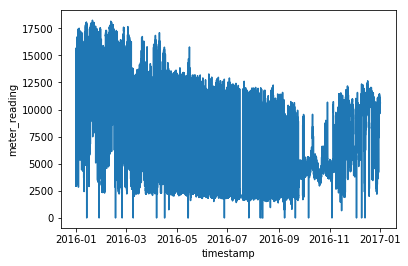

In [39]:
# steam
sns.lineplot(x='timestamp',y='meter_reading',data=df_one_building[df_train_total.meter == 2])

/home/jinpwa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


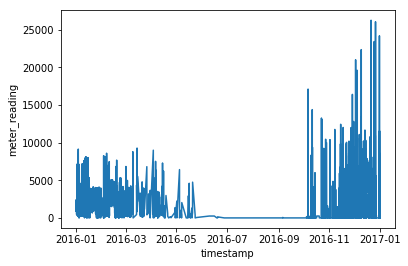

In [40]:
# hotwater
sns.lineplot(x='timestamp',y='meter_reading',data=df_one_building[df_train_total.meter == 3])

## multiple building

Now let's compare several buildings at the same time.

In [48]:
df_lots_building = df_train_total[df_train_total['building_id'].isin([1258,1298,1249])]

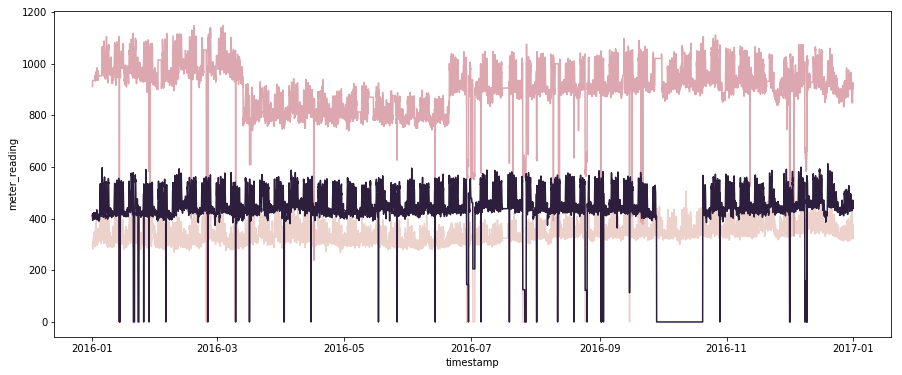

In [57]:
f, ax = plt.subplots(figsize=(15, 6))
ax = sns.lineplot(x='timestamp',y='meter_reading', hue = 'building_id',legend=False,
             data=df_lots_building[df_lots_building.meter == 0])

/home/jinpwa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


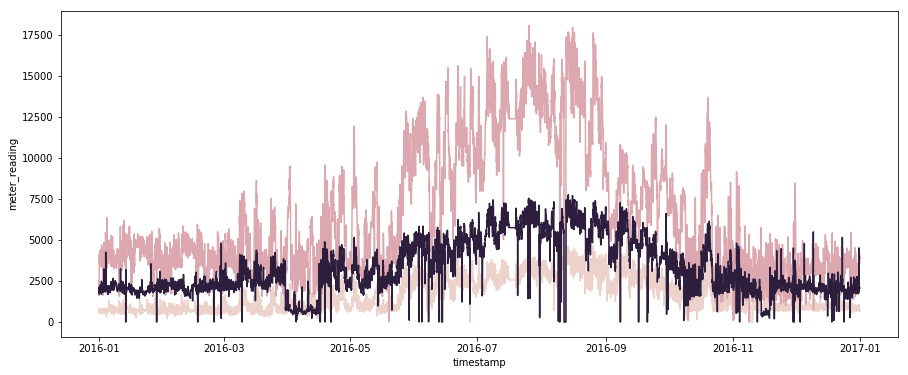

In [59]:
f, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x='timestamp',y='meter_reading',hue = 'building_id' ,legend=False,
             data=df_lots_building[df_train_total.meter == 1])

/home/jinpwa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


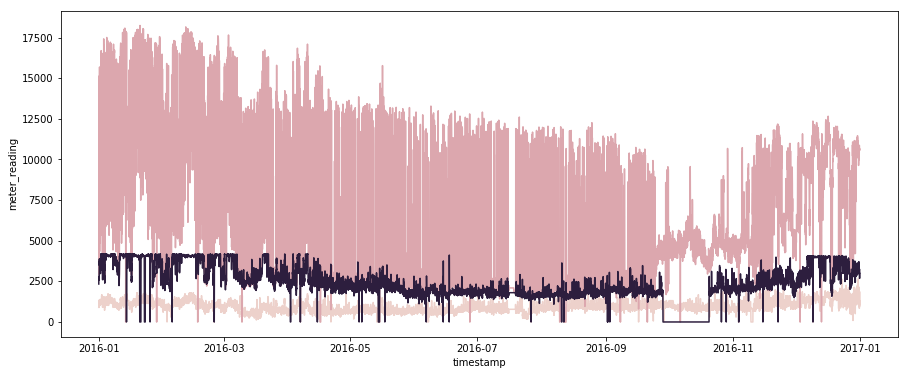

In [60]:
f, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x='timestamp',y='meter_reading',hue = 'building_id' ,legend=False,
             data=df_lots_building[df_train_total.meter == 2])

/home/jinpwa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


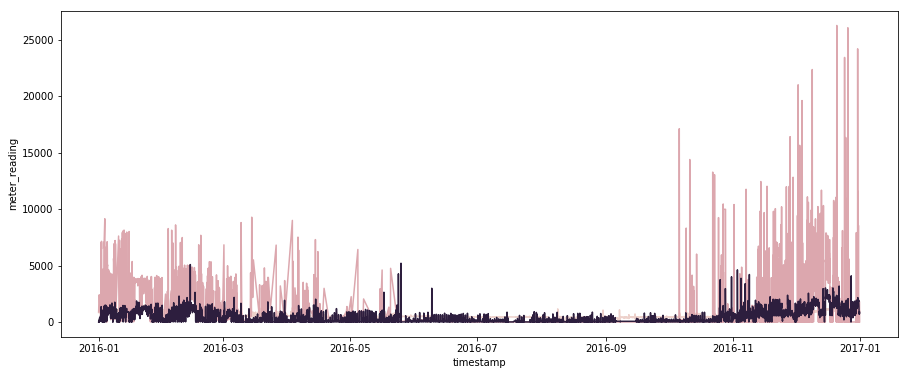

In [61]:
f, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(x='timestamp',y='meter_reading',hue = 'building_id' ,legend=False,
             data=df_lots_building[df_train_total.meter == 3])